In [1]:
import warnings
warnings.filterwarnings('ignore')

%reload_ext autotime

# Web Scraping for Indeed.com & Predicting Salaries

### Problem Statement:
#### Can salaries for Data Scientist job listings be predicted as high or low, in comparison to the median salary posted, using various features of the posting? What will best predict whether it's higher or lower than the median?

## Step I. Check out the data

In [2]:
import requests
from bs4 import BeautifulSoup
import datetime
import time
import re
import numpy as np

# I manully ran the search for data scienctist salaries and found the URL format
# The search is for title of data scientist and salary above $20,000

url = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000"

## x will indicate the number of the first listing on a particular page 
## each page lists 10 posts (and 5 sponsored posts)
page = requests.get(url).content
soup = BeautifulSoup(page,'lxml')

time: 966 ms


In [3]:
print soup

<!DOCTYPE html>
<html lang="en">
<head>
<meta content="text/html;charset=utf-8" http-equiv="content-type"/>
<!-- pll --><script src="/s/175b0c0/en_US.js" type="text/javascript"></script>
<link href="/s/bfd4a87/jobsearch_all.css" rel="stylesheet" type="text/css"/>
<link href="http://rss.indeed.com/rss?q=data+scientist+%2420%2C000" rel="alternate" title="Data Scientist $20,000 Jobs, Employment" type="application/rss+xml"/>
<link href="/m/jobs?q=data+scientist+%2420%2C000" media="handheld" rel="alternate"/>
<script type="text/javascript">
    
    if (typeof window['closureReadyCallbacks'] == 'undefined') {
        window['closureReadyCallbacks'] = [];
    }

    function call_when_jsall_loaded(cb) {
        if (window['closureReady']) {
            cb();
        } else {
            window['closureReadyCallbacks'].push(cb);
        }
    }
</script>
<script src="/s/71ea1e0/jobsearch-all-compiled.js" type="text/javascript"></script>
<script type="text/javascript">
var pingUrlsForGA = [];


#### Notes:

- The HTML can be narrowed down to the contents within ```<td id="resultsCol"> ... </td>```. This makes it easier to find what we're looking for by eliminating the script section and everything on the side panes.

In [4]:
print soup.find('td',{'id':'resultsCol'})

<td id="resultsCol">
<div class="messageContainer">
<script type="text/javascript">
function setJaPromoCookie() {
var expires = new Date();
expires.setTime(expires.getTime() + (5 * 365 * 24 * 60 * 60 * 1000));
setCookie("showJaPromo", "1", expires);
}
function setRefineByCookie(refineByTypes) {
var expires = new Date();
expires.setTime(expires.getTime() + (10 * 1000));
for (var i = 0; i < refineByTypes.length; i++) {
setCookie(refineByTypes[i], "1", expires);
}
}
</script>
</div>
<style type="text/css">
#increased_radius_result {
font-size: 16px;
font-style: italic;
}
#original_radius_result{
font-size: 13px;
font-style: italic;
color: #666666;
}
</style>
<div class="resultsTop"><div id="searchCount">Jobs 1 to 10 of 21,491</div>
<div data-tn-section="primePromo" id="primePromo">
<span class="new">New!</span> <a href="/promo/prime" onclick="this.href = appendParamsOnce( this.href, '?from=serptop&amp;subfrom=primeprmtop&amp;trk.origin=jobsearch&amp;trk.variant=primeprmtop&amp;trk.tk=1bhd

- We should grab our data listing by listing as opposed to scraping all jobs, then all companies, etc.. for the entire page. This will ensure that missing data won't throw off which values should belong to which job.

- To do this, we can make a list of each job posting because they're all in div tags with a class that ends in 'result.'  

- There are 5 sponsored jobs per page, and these all have funky class name variations. The 10 regular listings also have different class names. The following list contains all possible class names:

    "row result", "row sjlast result", " row result", "lastRow row result"

Using regex will eliminate the need to explicitly search for each of these tags. The following code will account for everything above.

In [5]:
print soup.find('td',{'id':'resultsCol'}).find_all('div', {'class': re.compile("result$")})[0]

<div class="row result" data-jk="bfc578d23604c2fc" id="pj_bfc578d23604c2fc">
<!-- Previously this variable was used to indicate job board jobs, we have replaced that with a more accurate source type check -->
<a class="jobtitle turnstileLink" data-tn-element="jobTitle" href="/pagead/clk?mo=r&amp;ad=-6NYlbfkN0D_L61JJZVH4SBayrvFEFSIDhxtpSFhtUBfRgL_yS-y4KQnwxgyzWhCsPoBnwyjC7i1224RkXyNjCKyMmAnielysSbfAScZoI_OgdN6cH2LUiHe9CeKg9jliNU9_-djYbNyJ2RAQGYO0xiVwMIc48Gv2SU4pEDHN7m15eB7x73iTEBPM8wde0m5wE7qft5c1dgVbTtYuirrJ2MXi9rtgLqz_3z08os3klbEk0GHijoK6eLDwntLPeFfr_xOkMIszVbY7ND_um_nHwqIVA9lBSsA7fBd3NYR17wN-15QAauVNP4tWBdZdpy033Nv_vgEHgH6O9Hz3KRwdtj2ZeLqnT1meQmHWf-Gnbw41IN0pJwRzm0hokMz9Q-UuyORdDuPt3-5X7v9N3IHUaeM7qKkWprW1kxiCaoU9Pefy2_xxl35xabC-xqCbXAyXSf2xvRndf9KyuYie6AYtnBm6V22pbM65uMS7kdZM0yFQhHpIG2GnKKG4vBrBxpn3yUYO7M8kX8kivKGnkynA9NIY8D1q_-hoTWIEn7l245CVw6AmDCRFdFTaqg8vqFCxXlxKvyk3UbduU1EpGT66HM8X5TebNvOoZUzvecR4zbrctZR8KUXa_3_xuhhS692adF_k0TENlH3kKF9ciTIzZh5WXG3cVszyFJf-wDh3E5ZxqeivjbXE-DXY-1R

- In order to make predictions about salaries, I want to collect the job title, company, location, description, and most importantly, SALARY.
- Create functions for finding each attribute for each job in the list, so that the overall webscraping script is easy to read

In [6]:
'''
Each function finds the specific HTML tag and/or attribute/ID 
that leads directly to the information needed.

In order to prevent errors, each has a 'try, except' statement.
Whenever a listing doesn't provide anything for any of the attributes,
we will simply 'pass' and essentially skip the attribute.
'''


def get_job(webpage):
    tag = webpage.find('a', title=True, attrs={'data-tn-element':'jobTitle'})
    try:
        return tag['title']
    except:
        pass

def get_company(webpage):
    tag = webpage.find('span', attrs={'class':'company'})
    try:
        return tag.text.strip('\n') # many company names are messy and have newline code that we can strip
    except:
        pass
    
def get_location(webpage):
    tag = webpage.find('span', attrs={'class':'location'})
    try:
        return tag.text
    except:
        pass    

def get_salary(webpage):
    try:
        return webpage.find('table').tr.td.nobr.renderContents() ## for regular listings
    except:
        try:
            return webpage.find('div').div.text ## for sponsored listings
        except:
            pass

def get_description(webpage):
    description = webpage.find('span', attrs={'itemprop':"description"})
    try:
        return description.text.strip('\n') # many descriptions have the newline code that can be stripped
    except:
        pass

time: 31.8 ms


- I found that some numbers are in a string and we can't just convert to a number with pandas. Below is a function to handle this:

In [2]:
## given a string of a number with commas, convert to float
def str_to_number(string):
    import locale 
    string = string.strip('$')
    locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') #for american comma notation
    num = locale.atof(string)
    return float(num)

time: 4.1 ms


## Step II. Scrape job postings from Indeed.com & Clean

The general outline of my scraper function is as follows:
- (for all runs post initial run) compile all previously collected data into a pandas dataframe
- Check the main page for the total number of listings, so the scraper knows how long to run
- For each page and for each job listing, use the attribute functions
- 
#### Spoiler!!
The following function scrapes the job postings, puts them into a Pandas dataframe, then exports them to a csv file.
- After running the scraper a few times, I decided that I wanted to begin the function by loading each previously exported list of jobs into a dataframe and try to only add new jobs that haven't already been exported.

In [3]:
## import the results that have been previously exported
def compile_files():
    import glob
    import pandas as pd
    import numpy as np
    indeed_csvs =  '../../DC-DSI4/projects/03-Project/indeed/'
    files = glob.glob(indeed_csvs + '*.csv') # get a list of the csv files
    indeed_final = pd.DataFrame(columns=['job','company','location','salary','description'])
    for f in files: # read each csv file in
        f = pd.read_csv(f, names=['job','company','location','salary','description'],low_memory=False)
        indeed_final = indeed_final.append(f)
    # drop duplicates, get rid of jobs without salaries
    indeed_final.drop_duplicates(inplace=True)
    indeed_final.dropna(subset=['salary'],how='any',inplace=True)

    print 'Size = ',len(indeed_final)
    print 'Salaries = ', len(indeed_final[indeed_final.salary.notnull()])

    return indeed_final

time: 14.1 ms


Without further ado, the scraping function! This includes everything noted in Step 1.

In [9]:
def scrape_indeed():
    
    '''
    /// 1/6. Compile previously scraped results to see if there are new jobs to add \\\
    '''
    indeed = compile_files()  
    indeed.reset_index(drop=True,inplace=True)
    base = len(indeed)
    
    
    
    '''
    /// 2/6. Set up function with necessary libraries, print status notifications, set URL format \\\
    '''
    import requests
    from bs4 import BeautifulSoup
    import datetime
    import time
    import re
    import numpy as np
    
    start = datetime.datetime.now()
    
    print 'Start time: ',start.strftime("%Y-%m-%d %H:%M:%S")
    print 'Base file has ', base, ' records'
    print 'Salaries = ', len(indeed[indeed.salary.notnull()])
    
    ## specify structure of URL. stop at 'start=' so that we can 
    ## dynamically change the URL and flip through pages of results
    url_base = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&fromage=last&start="
    

    
    '''
    /// 3/6. Find the total number of job listings for the search from the first page of results \\\
    '''
    x=0 # if we set the start variable in the URL to 0 to begin with, it will pull up results 1-10
    url = url_base+str(x) 

    page = requests.get(url).content
    soup = BeautifulSoup(page,'lxml')
    print 'Page scraped & souped'
    
    for results in soup.find('div', attrs={'id':'searchCount'}):
        count = str(results).split()         # take the full line that says 'Jobs x to y of z' and turn into a list
        total = count[len(count)-1]          # set total to z, the total number of results
        total = str_to_int(total) # since there are commas in numbers > 999, this function will deal with that and convert to int
        ## I've found that after a few hundred pages, no new jobs are found
        ## If we reduce the total by a bit, we can make sure the function isn't running
        ## for an unnecessary amount of time and making an unnecessary number of requests to Indeed.com
        total = total/5
                
        
    '''
    /// 4/6. Scrape!!! \\\
    '''
    while x <= total: 
        url_new_page = url + str(x)
        page = requests.get(url_new_page).content
        soup = BeautifulSoup(page,"lxml")
        
        # the top of the page says 'Showing results X through Y of Z.'
        # use this for status notification
        for num_listings in soup.find('div', attrs={'id':'searchCount'}) :
            num_listings = num_listings.split()[3]
        
        main = soup.find('td',{'id':'resultsCol'})   # limit our searching to solely the results portion of the page
        results = main.find_all('div', {'class': re.compile("result$")}) # create a list consisting only of the 15 results

        for i in range(len(results)):
            job = get_job(results[i])
            company = get_company(results[i])         # put all companies for each posting on curent results page into companies list
            location = get_location(results[i])       # put all locations for each posting on current results page into locations list
            salary = get_salary(results[i])           # put all salaries for each posting on current results page into salaries list
            description = get_description(results[i]) # put all descriptions for each posting on current results page into descriptions list

            add_job = pd.DataFrame([[job, company, location, salary, description]], columns = ['job','company','location','salary','description'])
            a = np.array(add_job)
            # If we don't already have this job, add it
            if (indeed == a).all(1).any() == False:
                indeed = indeed.append(add_job)                


        '''
        /// 5/6. Print status notifications and prep for next page of results
        '''       
        x+=10
        new = len(indeed) - base
        elapsed = datetime.datetime.now() - start
        remaining = total - x
        est_pages = remaining/10
        
        print 'Added ', new, ' jobs-- scraped ',num_listings,' of ', total, ' listings in ', elapsed, '; ', est_pages, ' pages remaining'
    
        time.sleep(0.5)
    
    
    '''
    /// 6/6. CONCLUSION. Print elapsed time and export results to CSV
    '''
    ## set a variable to use in the filename so that
    ## they're always unique and never overwritten
    finish = datetime.datetime.now()
    now = finish.strftime("%Y-%m-%d %H:%M:%S")
    elapsed = finish-start
    print 'Finish time: ',now
    print 'Elapsed: ',elapsed

    # export
    indeed = pd.DataFrame(indeed)
    indeed.drop_duplicates(inplace=True)
    indeed.to_csv('/Users/jennydoyle/Desktop/dsi/DC-DSI4/projects/03-Project/indeed/'+now+'.csv',sep=',', encoding='utf-8')
    return indeed

    print 'Base file has ', len(indeed), ' records'
    print 'Salaries = ', len(indeed[indeed.salary.notnull()])    

time: 212 ms


#### Load in the the data of scraped salaries

In [4]:
indeed = compile_files()
indeed.reset_index(drop=True,inplace=True)

Size =  795
Salaries =  795
time: 4.79 s


### Clean, clean, clean

#### Clean up salaries

In [5]:
import numpy as np

## create a sub-df consisting only of jobs with annual salaries
df=indeed[indeed.salary.notnull()&indeed.salary.str.contains('year')]
df.salary = df.salary.astype(str)
print "Number of annual salaries = ", len(df)

## Some salaries are listed as a range
## turn the salary into a list so we can grab the high and low ends, then average
df['salary_list'] = df.salary.str.split()

mask = df.salary.str.contains('-')
df['low_end'], df['high_end'], df['salary_clean'] = np.NaN, np.NaN, np.NaN
df['low_end'][mask] = map(lambda x: x[0],df.salary_list.loc[mask])
df['high_end'][mask] = map(lambda x: x[2],df.salary_list.loc[mask])

Number of annual salaries =  603
time: 475 ms


In [6]:
# Set the Salary_clean field = first element in salary list (intended to grab salaries that don't list a range)
df.salary_clean[df.salary.notnull()]= [x[0] for x in df.salary_list]
df.salary_clean[df.low_end.notnull()&df.high_end.notnull()] = np.NaN

# convert to numeric so that we can average the ranges
for col in ['salary_clean','low_end','high_end']:
    df[col][df[col].notnull()] = [str_to_number(x) for x in df[col][df[col].notnull()]]

# average out ranges
df.salary_clean[df.salary_clean.isnull()] = (df.low_end + df.high_end) / 2

time: 497 ms


#### Clean up locations

In [7]:
## remove areas in parentheses
df.location = df.location.str.upper()
df.location = df.location.str.replace('(\((.*?)\))','')
df.location = df.location.str.strip()

## remove zip codes
df.location = df.location.str.replace(r'(\d{5}(\-\d{4})?)$','')
df.location = df.location.str.strip()

time: 167 ms


In [8]:
## create feature with states
df['state'] = df.location.str.findall('\,\s(\D{2})$')
## hmm why is it in a list? take out
df.state = [i[0] if len(i)>0 else None for i in df.state]

## remove state from location
df.location = df.location.str.replace('(\,\s\D{2})$','')

time: 111 ms


#### Clean up companies

In [9]:
df.company = df.company.str.strip()
df.company = df.company.str.upper()

time: 73.2 ms


#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

In [10]:
###
### BINARY TARGET FEATURE -- above (1) median or below (0) 
###

df = df[df.salary_clean.notnull()]
median_salary = np.median(df.salary_clean)

# set our binary variable high_salary = 1, then wherever the clean salary is below the median, change to 0
df['high_salary'] = 1
df['high_salary'][df.salary_clean <= median_salary] = 0 

time: 83.6 ms


In [11]:
median_salary, len(df)

(87915.0, 603)

time: 17.7 ms


### Feature Engineering
Now it's time to think about what I can do with my existing features: Job, Company, Location, State, Description. I want to avoid features that would get too specific for the training set and wouldn't apply to the test set. With that said, I will eliminate the Job and Company features because they're not clean and too specific.

My plan is, however, to use job titles to create more general features that I can flag for each job. I also will create a count vectorizer to pull in the descriptions.

#### Job Title Keywords

In [12]:
df.job = df.job.str.upper()
df['analyst'] = 0
df['analyst'][df.job.str.contains('ANALY')] = 1

df['statistician'] = 0
df['statistician'][df.job.str.contains('STATISTIC')] = 1

df['machine_learning'] = 0
df['machine_learning'][df.job.str.contains('MACHINE')] = 1

df['research'] = 0
df['research'][df.job.str.contains('RESEARCH')] = 1

df['science'] = 0
df['science'][df.job.str.contains('SCIEN')] = 1

df['engineer'] = 0
df['engineer'][df.job.str.contains('ENGIN')] = 1

df['entry_level'] = 0
df['entry_level'][df.job.str.contains('\WI\W')] = 1
df['entry_level'][df.job.str.contains('\WI$')] = 1
df['entry_level'][df.job.str.contains('ENTRY_LEVEL')] = 1
df['entry_level'][df.job.str.contains('1')] = 1

df['mid_level'] = 0
df['mid_level'][df.job.str.contains('MANAGER')] = 1
df['mid_level'][df.job.str.contains('MID_LEVEL')] = 1
df['mid_level'][df.job.str.contains('\WII\W')] = 1
df['mid_level'][df.job.str.contains('\WII$')] = 1
df['mid_level'][df.job.str.contains('2')] = 1
df['mid_level'][df.job.str.contains('ASSISTANT')] = 1

df['senior_level'] = 0
df['senior_level'][df.job.str.contains('\WIII\W')] = 1
df['senior_level'][df.job.str.contains('\WIII$')] = 1
df['senior_level'][df.job.str.contains('3')] = 1
df['senior_level'][df.job.str.contains('SR\W')] = 1
df['senior_level'][df.job.str.contains('SENIOR')] = 1
df['senior_level'][df.job.str.contains('LEAD')] = 1
df['senior_level'][df.job.str.contains('PRINCIPAL')] = 1
df['senior_level'][df.job.str.contains('DIRECTOR')] = 1


time: 949 ms


#### Job Description - Count Vectorizer

In [13]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

df.reset_index(inplace=True)

df.fillna('None',inplace=True)

cvec = CountVectorizer(stop_words='english')
cvec.fit(df['description'])

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

time: 3.84 s


In [14]:
cvec_table  = pd.DataFrame(cvec.transform(df['description']).todense(),
             columns=cvec.get_feature_names())

time: 62.9 ms


In [15]:
from sklearn.preprocessing import StandardScaler 

scale_me = []
dont_scale_me = []

for col in cvec_table.columns:
    if cvec_table[col].max() > 1:
        scale_me.append(col)
    else:
        dont_scale_me.append(col)
        

ss = pd.DataFrame(StandardScaler().fit_transform(cvec_table[scale_me]),columns=scale_me)
cvec = pd.merge(cvec_table[dont_scale_me],ss,right_index=True, left_index=True)

time: 534 ms


In [16]:
include = df.columns.drop(['location','state','index','job','company','salary','description','salary_list','low_end','high_end','salary_clean','high_salary'])
# new_df = pd.get_dummies(df[include],columns=['location','state'])

time: 2.65 ms


In [17]:
# new_df = pd.merge(new_df,cvec,right_index=True, left_index=True)

new_df = pd.merge(df[include],cvec,right_index=True, left_index=True)

time: 15.1 ms


## Step IV. Modelling

In [19]:
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split

# set y
y = df.high_salary

time: 405 ms


In [20]:
X = new_df
y = df.high_salary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

time: 79.8 ms


#### Treez

Now I'm going to look at RandomForest, ExtraTrees and check out the feature importance. I'll experiment with the number of features to use, and with bagging and boosting. I'll also use these features back on Logistic Regression, since it doesn't have the feature_importances attribute.

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier

time: 2.96 ms


In [26]:
def test_features(model,X_train,y_train):
    model.fit(X_train,y_train)
    features = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns), key=lambda pair: pair[0], reverse=True),columns=['Importance','Feature'])
    
    for nums in [len(features),500,300,200,100,60,30,20]:   
        X_train_new = X_train[features.Feature[0:nums]]
        s = cross_val_score(model, X_train_new, y_train, cv=5, n_jobs=-1)

        print '0:',nums,'--', s.mean().round(3), s.std().round(3)

    print
    print 'try with Bagging:'
    for nums in [len(features),500,300,200,100,60,30,20]:   
        X_train_new = X_train[features.Feature[0:nums]]
        s = cross_val_score(BaggingClassifier(model), X_train_new, y_train, cv=5, n_jobs=-1)

        print '0:',nums,'--', s.mean().round(3), s.std().round(3)

#     print
#     print 'try with AdaBoost:'
#     for nums in [len(features),500,300,200,100,60,30,20]:   
#         X_train_new = X_train[features.Feature[0:nums]]
#         s = cross_val_score(AdaBoostClassifier(model), X_train_new, y_train, cv=5, n_jobs=-1)

#         print '0:',nums,'--', s.mean().round(3), s.std().round(3)
            
    print
    print 'try with Logistic Regression:'
    for nums in [len(features),500,300,200,100,60,30,20]:   
        X_train_new = X_train[features.Feature[0:nums]]
        s = cross_val_score(LogisticRegression(), X_train_new, y_train, cv=5, n_jobs=-1)

        print '0:',nums,'--', s.mean().round(3), s.std().round(3)
      
    
    print
    print 'try with Logistic Regression & BAGGING:'
    for nums in [len(features),500,300,200,100,60,30,20]:   
        X_train_new = X_train[features.Feature[0:nums]]
        s = cross_val_score(BaggingClassifier(LogisticRegression()), X_train_new, y_train, cv=5, n_jobs=-1)

        print '0:',nums,'--', s.mean().round(3), s.std().round(3)        

time: 47.6 ms


In [30]:
test_features(RandomForestClassifier(),X_train,y_train)   
# 0: 549 -- 0.698 0.026
# 0: 300 -- 0.698 0.016
# 0: 200 -- 0.693 0.048
# 0: 100 -- 0.714 0.013
# 0: 60 -- 0.711 0.04
# 0: 30 -- 0.758 0.041
# 0: 20 -- 0.735 0.033

# try with Bagging:
# 0: 549 -- 0.678 0.027
# 0: 300 -- 0.683 0.025
# 0: 200 -- 0.685 0.03
# 0: 100 -- 0.696 0.01
# 0: 60 -- 0.693 0.038
# 0: 30 -- 0.745 0.037
# 0: 20 -- 0.727 0.031

# try with AdaBoost:
# 0: 549 -- 0.698 0.019
# 0: 300 -- 0.693 0.022
# 0: 200 -- 0.714 0.003
# 0: 100 -- 0.729 0.02
# 0: 60 -- 0.734 0.024
# 0: 30 -- 0.755 0.042
# 0: 20 -- 0.732 0.032

# try with Logistic Regression:
# 0: 549 -- 0.704 0.017
# 0: 300 -- 0.691 0.029
# 0: 200 -- 0.696 0.029
# 0: 100 -- 0.706 0.019
# 0: 60 -- 0.706 0.03
# 0: 30 -- 0.717 0.053
# 0: 20 -- 0.729 0.042
# time: 1min 19s

0: 2019 -- 0.73 0.047
0: 500 -- 0.755 0.028
0: 300 -- 0.752 0.022
0: 200 -- 0.752 0.055
0: 100 -- 0.752 0.027
0: 60 -- 0.765 0.057
0: 30 -- 0.74 0.018
0: 20 -- 0.713 0.035

try with Bagging:
0: 2019 -- 0.75 0.038
0: 500 -- 0.762 0.035
0: 300 -- 0.767 0.029
0: 200 -- 0.785 0.047
0: 100 -- 0.765 0.043
0: 60 -- 0.77 0.037
0: 30 -- 0.745 0.011
0: 20 -- 0.73 0.026

try with Logistic Regression:
0: 2019 -- 0.708 0.04
0: 500 -- 0.738 0.046
0: 300 -- 0.782 0.027
0: 200 -- 0.797 0.028
0: 100 -- 0.787 0.02
0: 60 -- 0.777 0.027
0: 30 -- 0.75 0.023
0: 20 -- 0.747 0.027

try with Logistic Regression & BAGGING:
0: 2019 -- 0.703 0.025
0: 500 -- 0.74 0.032
0: 300 -- 0.765 0.024
0: 200 -- 0.772 0.023
0: 100 -- 0.77 0.028
0: 60 -- 0.762 0.028
0: 30 -- 0.755 0.036
0: 20 -- 0.74 0.039
time: 29.9 s


In [31]:
model = RandomForestClassifier(bootstrap= True, min_samples_leaf= 1, n_estimators= 300, min_samples_split= 2,criterion='entropy',max_features= 3, max_depth= 3)
test_features(model,X_train,y_train)    


# 0: 549 -- 0.534 0.003
# 0: 300 -- 0.546 0.008
# 0: 200 -- 0.58 0.017
# 0: 100 -- 0.616 0.019
# 0: 60 -- 0.678 0.016
# 0: 30 -- 0.652 0.033
# 0: 20 -- 0.657 0.028

# try with Bagging:
# 0: 549 -- 0.536 0.008
# 0: 300 -- 0.549 0.019
# 0: 200 -- 0.564 0.022
# 0: 100 -- 0.634 0.045
# 0: 60 -- 0.678 0.03
# 0: 30 -- 0.657 0.029
# 0: 20 -- 0.647 0.032

# try with AdaBoost:
# 0: 549 -- 0.693 0.011
# 0: 300 -- 0.719 0.032
# 0: 200 -- 0.729 0.032
# 0: 100 -- 0.722 0.019
# 0: 60 -- 0.709 0.018
# 0: 30 -- 0.688 0.034
# 0: 20 -- 0.678 0.033

# try with Logistic Regression:
# 0: 549 -- 0.704 0.017
# 0: 300 -- 0.706 0.029
# 0: 200 -- 0.719 0.036
# 0: 100 -- 0.714 0.017
# 0: 60 -- 0.706 0.016
# 0: 30 -- 0.688 0.034
# 0: 20 -- 0.678 0.033
# time: 41min 18s

0: 2019 -- 0.535 0.022
0: 500 -- 0.688 0.056
0: 300 -- 0.711 0.035
0: 200 -- 0.74 0.037
0: 100 -- 0.73 0.024
0: 60 -- 0.738 0.038
0: 30 -- 0.718 0.035
0: 20 -- 0.73 0.045

try with Bagging:
0: 2019 -- 0.614 0.109
0: 500 -- 0.676 0.105
0: 300 -- 0.708 0.078
0: 200 -- 0.738 0.057
0: 100 -- 0.765 0.037
0: 60 -- 0.728 0.055
0: 30 -- 0.718 0.032
0: 20 -- 0.73 0.045

try with Logistic Regression:
0: 2019 -- 0.708 0.04
0: 500 -- 0.755 0.024
0: 300 -- 0.743 0.034
0: 200 -- 0.77 0.032
0: 100 -- 0.762 0.035
0: 60 -- 0.743 0.018
0: 30 -- 0.733 0.033
0: 20 -- 0.742 0.044

try with Logistic Regression & BAGGING:
0: 2019 -- 0.695 0.042
0: 500 -- 0.735 0.046
0: 300 -- 0.72 0.042
0: 200 -- 0.757 0.046
0: 100 -- 0.757 0.05
0: 60 -- 0.755 0.044
0: 30 -- 0.733 0.04
0: 20 -- 0.74 0.04
time: 8min 46s


In [32]:
model = RandomForestClassifier(bootstrap= True, min_samples_leaf= 1, n_estimators= 300, min_samples_split= 2,criterion='entropy',max_features= 3, max_depth= 3)
test_features(model,X_train,y_train)    



# 0: 549 -- 0.534 0.003
# 0: 300 -- 0.549 0.015
# 0: 200 -- 0.549 0.017
# 0: 100 -- 0.634 0.029
# 0: 60 -- 0.67 0.028
# 0: 30 -- 0.667 0.033
# 0: 20 -- 0.66 0.025

# try with Bagging:
# 0: 549 -- 0.534 0.003
# 0: 300 -- 0.541 0.01
# 0: 200 -- 0.557 0.022
# 0: 100 -- 0.611 0.038
# 0: 60 -- 0.639 0.046
# 0: 30 -- 0.675 0.036
# 0: 20 -- 0.66 0.025

# try with AdaBoost:
# 0: 549 -- 0.693 0.023
# 0: 300 -- 0.727 0.022
# 0: 200 -- 0.763 0.013
# 0: 100 -- 0.719 0.007
# 0: 60 -- 0.727 0.015
# 0: 30 -- 0.688 0.021
# 0: 20 -- 0.662 0.021

# try with Logistic Regression:
# 0: 549 -- 0.704 0.017
# 0: 300 -- 0.719 0.026
# 0: 200 -- 0.732 0.017
# 0: 100 -- 0.711 0.01
# 0: 60 -- 0.722 0.019
# 0: 30 -- 0.683 0.034
# 0: 20 -- 0.66 0.025
# time: 36min 15s
# In [84]:



0: 2019 -- 0.552 0.026
0: 500 -- 0.666 0.04
0: 300 -- 0.715 0.056
0: 200 -- 0.713 0.04
0: 100 -- 0.758 0.039
0: 60 -- 0.755 0.048
0: 30 -- 0.73 0.041
0: 20 -- 0.723 0.04

try with Bagging:
0: 2019 -- 0.666 0.056
0: 500 -- 0.74 0.052
0: 300 -- 0.75 0.053
0: 200 -- 0.777 0.026
0: 100 -- 0.767 0.04
0: 60 -- 0.753 0.044
0: 30 -- 0.725 0.047
0: 20 -- 0.715 0.036

try with Logistic Regression:
0: 2019 -- 0.708 0.04
0: 500 -- 0.735 0.043
0: 300 -- 0.75 0.05
0: 200 -- 0.758 0.027
0: 100 -- 0.755 0.033
0: 60 -- 0.758 0.033
0: 30 -- 0.73 0.025
0: 20 -- 0.728 0.036

try with Logistic Regression & BAGGING:
0: 2019 -- 0.715 0.05
0: 500 -- 0.718 0.036
0: 300 -- 0.73 0.036
0: 200 -- 0.738 0.024
0: 100 -- 0.743 0.036
0: 60 -- 0.75 0.025
0: 30 -- 0.72 0.036
0: 20 -- 0.728 0.036
time: 8min 35s


In [33]:
test_features(ExtraTreesClassifier(),X_train,y_train)   

# 0: 549 -- 0.709 0.026
# 0: 300 -- 0.693 0.024
# 0: 200 -- 0.722 0.03
# 0: 100 -- 0.763 0.03
# 0: 60 -- 0.753 0.017
# 0: 30 -- 0.747 0.026
# 0: 20 -- 0.737 0.045

# try with Bagging:
# 0: 549 -- 0.709 0.017
# 0: 300 -- 0.709 0.02
# 0: 200 -- 0.724 0.038
# 0: 100 -- 0.755 0.029
# 0: 60 -- 0.737 0.034
# 0: 30 -- 0.748 0.042
# 0: 20 -- 0.745 0.052

# try with AdaBoost:
# 0: 549 -- 0.691 0.031
# 0: 300 -- 0.709 0.019
# 0: 200 -- 0.719 0.041
# 0: 100 -- 0.766 0.024
# 0: 60 -- 0.76 0.026
# 0: 30 -- 0.745 0.035
# 0: 20 -- 0.742 0.039

# try with Logistic Regression:
# 0: 549 -- 0.704 0.017
# 0: 300 -- 0.701 0.02
# 0: 200 -- 0.724 0.039
# 0: 100 -- 0.742 0.038
# 0: 60 -- 0.729 0.02
# 0: 30 -- 0.722 0.029
# 0: 20 -- 0.711 0.052
# time: 1min 20s

0: 2019 -- 0.775 0.014
0: 500 -- 0.75 0.051
0: 300 -- 0.777 0.022
0: 200 -- 0.767 0.041
0: 100 -- 0.787 0.034
0: 60 -- 0.745 0.029
0: 30 -- 0.728 0.045
0: 20 -- 0.693 0.009

try with Bagging:
0: 2019 -- 0.775 0.035
0: 500 -- 0.77 0.015
0: 300 -- 0.782 0.041
0: 200 -- 0.787 0.046
0: 100 -- 0.794 0.044
0: 60 -- 0.76 0.032
0: 30 -- 0.742 0.037
0: 20 -- 0.728 0.014

try with Logistic Regression:
0: 2019 -- 0.708 0.04
0: 500 -- 0.738 0.021
0: 300 -- 0.752 0.029
0: 200 -- 0.767 0.027
0: 100 -- 0.78 0.033
0: 60 -- 0.78 0.03
0: 30 -- 0.765 0.029
0: 20 -- 0.752 0.039

try with Logistic Regression & BAGGING:
0: 2019 -- 0.723 0.025
0: 500 -- 0.743 0.031
0: 300 -- 0.75 0.027
0: 200 -- 0.752 0.027
0: 100 -- 0.752 0.042
0: 60 -- 0.75 0.038
0: 30 -- 0.76 0.013
0: 20 -- 0.75 0.03
time: 31.2 s


In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


names = ["Nearest Neighbors", 
         "Linear SVM",
         "RBF SVM",
         "Decision Tree",
#          "Random Forest", 
         "Naive Bayes"]
classifiers = [
    KNeighborsClassifier(5),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    GaussianNB()]

# a few of these classifiers don't have the feature_importances attribute, so we will use these features for them
model = RandomForestClassifier().fit(X_train,y_train)
features = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns), key=lambda pair: pair[0], reverse=True),columns=['Importance','Feature'])
features = features[features.Importance>0]

for clf,name in zip(classifiers,names):
    print name
    print '=================='
    try:
        test_features(clf,X_train,y_train)
    except:
        for nums in [len(features),500,300,200,100,60,30,20]:   
            X_train_new = X_train[features.Feature[0:nums]]
            s = cross_val_score(clf, X_train_new, y_train, cv=5, n_jobs=-1)

            print '0:',nums,'--', s.mean().round(3), s.std().round(3)

    print
    print

Nearest Neighbors
0: 646 -- 0.634 0.041
0: 500 -- 0.646 0.061
0: 300 -- 0.681 0.057
0: 200 -- 0.676 0.045
0: 100 -- 0.669 0.069
0: 60 -- 0.661 0.053
0: 30 -- 0.723 0.048
0: 20 -- 0.72 0.042


Linear SVM
0: 646 -- 0.71 0.036
0: 500 -- 0.72 0.042
0: 300 -- 0.725 0.055
0: 200 -- 0.745 0.039
0: 100 -- 0.738 0.042
0: 60 -- 0.728 0.044
0: 30 -- 0.71 0.047
0: 20 -- 0.715 0.055


RBF SVM
0: 646 -- 0.579 0.006
0: 500 -- 0.579 0.006
0: 300 -- 0.582 0.003
0: 200 -- 0.582 0.003
0: 100 -- 0.584 0.009
0: 60 -- 0.567 0.023
0: 30 -- 0.671 0.044
0: 20 -- 0.658 0.048


Decision Tree
0: 2019 -- 0.71 0.026
0: 500 -- 0.747 0.037
0: 300 -- 0.75 0.042
0: 200 -- 0.752 0.049
0: 100 -- 0.755 0.052
0: 60 -- 0.757 0.051
0: 30 -- 0.76 0.046
0: 20 -- 0.772 0.057

try with Bagging:
0: 2019 -- 0.713 0.056
0: 500 -- 0.755 0.049
0: 300 -- 0.75 0.05
0: 200 -- 0.757 0.054
0: 100 -- 0.755 0.046
0: 60 -- 0.757 0.047
0: 30 -- 0.757 0.047
0: 20 -- 0.745 0.044

try with Logistic Regression:
0: 646 -- 0.72 0.034
0: 500 -- 0.71

In [ ]:
from __future__ import division
def do_cm_cr(model, X, y):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
    X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.33, random_state=42)
    model.fit(X_train, y_train)
    expected = y_test
    predicted = model.predict(X_test)
    c_report = classification_report(expected, predicted)
#     c_report = pd.DataFrame(c_report)
    c_matrix = pd.DataFrame(confusion_matrix(y_test, predicted),columns=['Predicted No','Predicted Yes'],index=['Actual No','Actual Yes'])
#     return c_report, c_matrix
    from IPython.display import display

    print c_report
    TP = c_matrix['Predicted Yes'][1]
    FP = c_matrix['Predicted Yes'][0]
    TN = c_matrix['Predicted No'][1]
    FN = c_matrix['Predicted No'][0]
    N = TP + FP + TN + FN
    display(c_matrix)
    print 'TP:', TP
    print 'FP:', FP
    print 'TN:', TN
    print 'FN:', FN
    print 'Sensitivity:', TP / (TP + FN)
    print 'Specificity:', TN / (TN + FP)
    print 'Accuracy:', (TP + TN) / N
    print 'Precision:', TP / (TP + FP) 

do_cm_cr(model, X, y)

In [ ]:
predictions = model.predict(X_test)

# results = pd.DataFrame(sorted(zip(df_final.analyst, df_final['Los Angeles'], df_final.Queens, df_final.engineer, df_final['New York'],df_final.machine_learning,df_final.high_salary,predictions), key=lambda pair: pair[0], reverse=True),columns=['analyst', 'Reston', 'Los Angeles', 'Queens', 'engineer', 'New York','machine_learning','SALARY_HIGH','PREDICTION'])
# results['CORRECT']='Yes'
# results['CORRECT'][results.SALARY_HIGH!=results.PREDICTION]='No'

In [ ]:

dummies = pd.get_dummies(df_final, columns=['location'])
dummies.drop

# df = pd.concat([dummies, cvec_table,  df_final[['job','company','description','location','high_salary','salary_clean','analyst','statistician','engineer','machine_learning','research','mid_level','entry_level','senior_level']]], axis=1)
# X = pd.concat([dummies, cvec_table, df_final[['analyst','statistician','engineer','machine_learning','research','mid_level','entry_level','senior_level']]], axis=1)
# X = dummies.join(cvec_table)
X = cvec_table
# X.drop(X.index[177],inplace=True)
# X.drop([u'analyst', u'company', u'description', u'engineer', u'job','high_salary','salary_clean'],inplace=True,axis=1)
X.fillna(0,inplace=True)
y = list(df_final.high_salary.values)
features = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
dtypes_x = pd.DataFrame(list(X_train.dtypes))
cols_x = pd.DataFrame(list(X_train.columns),columns=['col'])
t = dtypes_x.join(cols_x)
# array([dtype('float64'), dtype('uint8'), dtype('O'), dtype('int64')], dtype=object)
model = RandomForestClassifier(bootstrap = True, min_samples_leaf= 1, n_estimators= 300, min_samples_split= 2, criterion= 'entropy',max_features= 3, max_depth= 3).fit(X_train,y_train)
model.score(X_train,y_train)

In [ ]:
model.score(X_test,y_test)

In [ ]:
model.score(X,y)

In [ ]:
## Create a df of the features and their scores, descending
feature_importances = sorted(zip(model.feature_importances_,features), key=lambda pair: pair[0], reverse=True)
feature_importances = pd.DataFrame(feature_importances,columns=['importance','feature'])
feature_importances

In [ ]:
## I don't want to use all of the features, just the important ones
## even though most have low scores ... 
features = list(feature_importances.feature[0:60])

X_2 = X[features]
# y = list(df_final.high_salary.values)

features = X_2.columns

X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(bootstrap = True, min_samples_leaf= 1, n_estimators= 300, min_samples_split= 2, criterion= 'entropy',max_features= 3, max_depth= 3).fit(X_train,y_train)
model.score(X_train,y_train)

In [ ]:
model.score(X_test,y_test)

In [ ]:
model.score(X_2,y)

In [ ]:
do_cm_cr(model, X_2, y)

In [ ]:
%matplotlib inline

LR: 0.741202 (0.088421)
LDA: 0.722923 (0.058980)
KNN: 0.689727 (0.073203)
CART: 0.747732 (0.065757)
RF: 0.751066 (0.070394)
NB: 0.714672 (0.089286)
SVM: 0.465738 (0.088370)


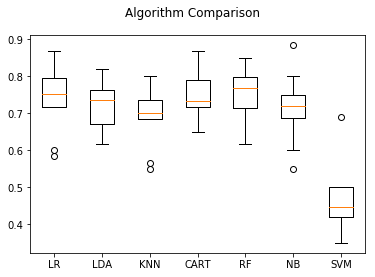

time: 8.7 s


In [36]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid=[{'C':  [10**-4, 10**-2, 10**0, 10**2, 10**4],'penalty' :['l1','l2']
        ,'solver':['liblinear']}]
model = LogisticRegression()
grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=5)
grid_search.fit(X_2, y)
print grid_search.best_params_
print grid_search.best_score_        

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid=[{'C':  [10**-4, 10**-2, 10**0, 10**2, 10**4],'penalty' :['l1','l2']
        ,'solver':['liblinear']}]
model = LogisticRegression()
grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=5)
grid_search.fit(X, y)
print grid_search.best_params_
print grid_search.best_score_        